正如前面提到,本章及接下来的部分都使用proplot库来完成绘图
本章先介绍一维数据的绘图,
用于举例子的两个数据(即时间序列)为1951-2020的D(-1)JF的Nino34和MAM的热带印度洋海温指数(40–110°E,20°S–20°N)
(之所以没用随机序列举例子是为了跟前面的数据读取部分串联起来)

In [1]:
# 先导入库
import numpy as np
import xarray as xr
import proplot as plot

In [2]:
# 读取数据,得到两个时间序列
# 用函数来解决
def get_4seasons_SST_5120(path, lat_range):
    """
    path: 文件路径
    lat_range: 纬度范围(例如:np.arange(60, -62, -2))

    Return:
    lat: 纬度
    lon: 经度
    SST_4seasons_5120: 变量的数组(year, seasons, lat, lon)

    (后面有机会再写成更加通用的函数)
    """

    data = xr.open_dataset(path)
    data = data.sel(lat=lat_range, time=slice('1950-01-01', '2020-12-31'))
    lat = data.lat.data
    lon = data.lon.data
    sst = data['sst'].data

    SST_4seasons_5120 = np.empty((70, 4, len(lat), len(lon)))
    for i in range(70):
        for season in range(4):
            index = 11 + 12*i + 3*season
            SST_4seasons_5120[i, season] = sst[index:index+3].mean(axis=0)

    # !!!扣除线性趋势(务必注意,除非是研究长期趋势的问题,否则都需要扣除长期线性趋势)
    for season in range(4):
        for i in range(len(lat)):
            for j in range(len(lon)):
                if (np.isnan(SST_4seasons_5120[:, season, i, j].sum())):  # 排掉陆地值点
                    SST_4seasons_5120[:, season, i, j] = np.nan
                else:
                    x = np.arange(1, 71, 1)
                    z = np.polyfit(x,SST_4seasons_5120[:, season, i, j], 1) #用线性回归拟合出长期线性趋势
                    y = np.polyval(z, x)

                    SST_4seasons_5120[:, season, i, j] = SST_4seasons_5120[:, season, i, j] - y

    return lat, lon, SST_4seasons_5120

# 自动化计算区域平均指数的函数(例如计算JJA的Nino34指数)
def cal_area_index(array_yearly, lat, lon, lat_range, lon_range):
    """
    array_yearly: 需要求解区域均值变量的场数据(year, lat, lon)
    lat: array_yearly对应的纬度(1d array)
    lon: array_yearly对应的经度(1d array)
    lat_range: 纬度范围(list)
    lon_range: 经度范围(list)

    Return:
    area_index: 指数序列(1d array)

    Note: 此函数处理不了跨域lon=360的情况
    """

    # 得到纬度和经度的索引
    lat_min = min(lat_range)
    lat_max = max(lat_range)
    lat_index = (lat>=lat_min) & (lat<=lat_max)

    lon_min = min(lon_range)
    lon_max = max(lon_range)
    lon_index = (lon>=lon_min) & (lon<=lon_max)

    # 得到区域均值
    temp = array_yearly[:, lat_index]
    temp = temp[:, :, lon_index]
    area_index = np.nanmean(np.nanmean(temp, axis=-1), axis=-1)

    return area_index

lat_sst, lon_sst, sst_4seasons_5120 = get_4seasons_SST_5120(r'data/sst.mnmean_new.nc',
                                                            np.arange(60, -62, -2) # 等价于slice(60, -60)
                                                            )

# -----------------------------------------------------------------------

Nino34_DJF_5120 = cal_area_index(sst_4seasons_5120[:, 0],
                                 lat_sst, lon_sst, [-6, 6], [190, 240])
TIOB_MAM_5120 = cal_area_index(sst_4seasons_5120[:, 1],
                               lat_sst, lon_sst, [-20, 20], [40, 110])

<a list of 2 PolyCollection objects>

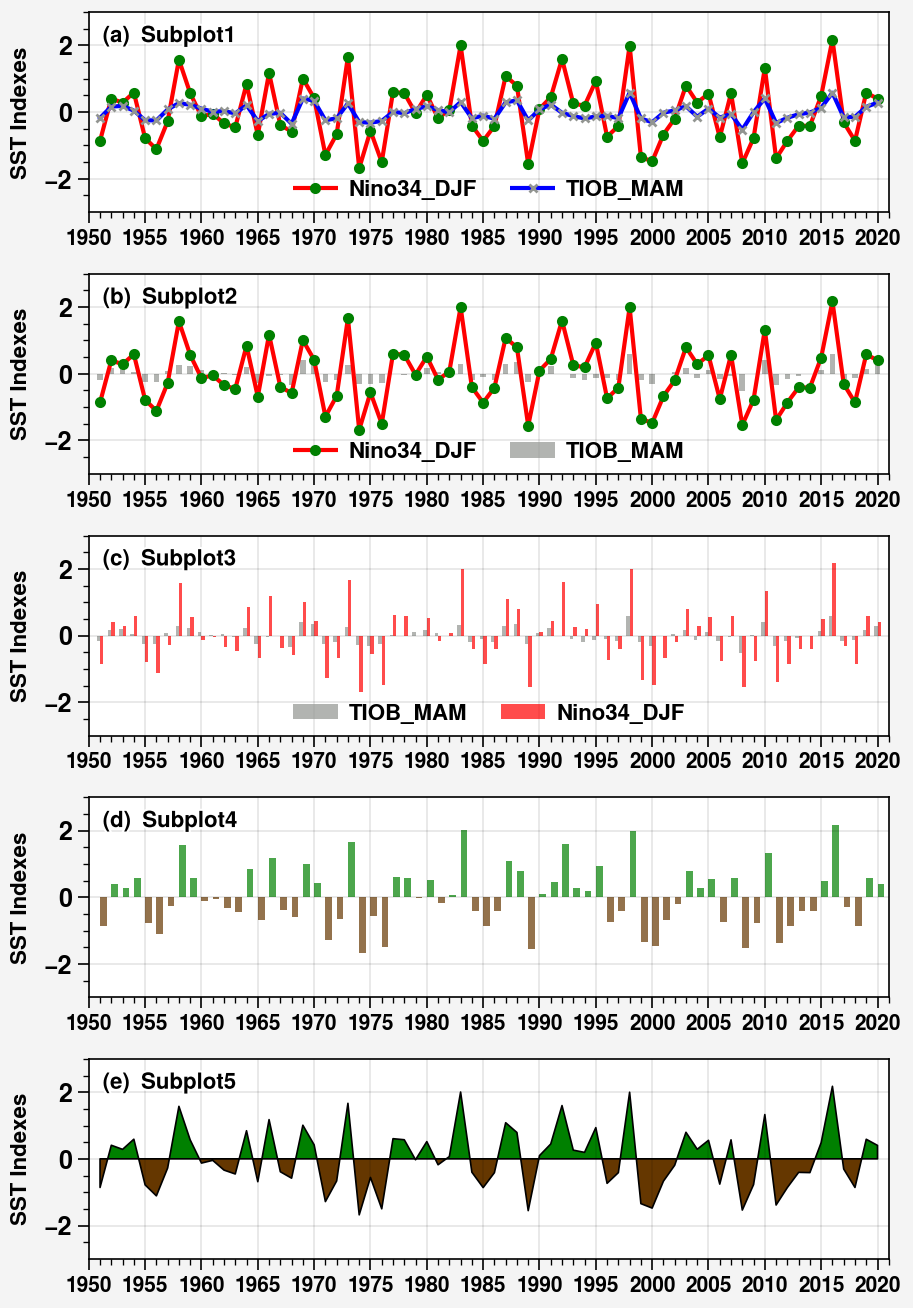

In [3]:
# 创建5个子图,即演示子图的创建,又演示不同的样式
subplot_array = [[1],
                 [2],
                 [3],
                 [4],
                 [5]] # 子图的布局,1表示第一幅子图,2表示第二幅子图...
fig, axs = plot.subplots(subplot_array, axwidth=4, refaspect=4, # axwidth为子图宽度, refaspect为子图长宽比
                         sharex=False, sharey=False, # 不共享x轴和y轴标签
                         )
axs.format(abc='(a)', # 规定子图的abc标签的样式
           abcloc='ul', # 规定子图的abc标签的位置 ul表示左上角(upper left)
           abcsize=8, # 子图的abc标签大小
           ylim=(-3, 3), # y轴范围
           xlim=(1950, 2021), # x轴范围
           ylabel='SST Indexes', # y轴标签
           ylabelsize=8, # y轴标签字体大小
           ylabelweight='heavy', # y轴标签字体粗细
           xticks=5,  # x轴刻度数量
           xtickminor=True, # x轴是否显示次刻度
           xticklabelsize=7.5, # x轴刻度字体大小
           ticklabelweight='bold', # x轴刻度字体粗细
           titlesize=8,  # 子图标题字体大小
           titleweight='bold' # 子图标题字体粗细
           )

axs[0].format(ultitle='Subplot1') # 子图1的标题, upper left title
axs[1].format(ultitle='Subplot2') # 子图2的标题
axs[2].format(ultitle='Subplot3') # 子图3的标题
axs[3].format(ultitle='Subplot4') # 子图4的标题
axs[4].format(ultitle='Subplot5') # 子图5的标题

# 绘制子图1
axs[0].plot(np.arange(1951, 2021, 1), Nino34_DJF_5120,
            color='red', linewidth=1.5, linestyle='-',
            marker='o', # 标记点的形状
            markersize=3, # 标记点的大小
            markercolor='green', # 标记点的颜色
            markeredgecolor='green', # 标记点的边缘颜色
            label='Nino34_DJF')
axs[0].plot(np.arange(1951, 2021, 1), TIOB_MAM_5120,
            color='blue', linewidth=1.5, linestyle='-',
            marker='x', # 标记点的形状
            markersize=3, # 标记点的大小
            markercolor='gray', # 标记点的颜色
            markeredgecolor='gray', # 标记点的边缘颜色
            label='TIOB_MAM')
axs[0].legend(loc='lc', # 图例的位置 lc表示左下角(lower center)
              ncols=2,  # 图例的列数
              fontweight='heavy', # 字体粗细
              prop = {'size':8}, # 字体大小
              framealpha=0 # 图例边框的透明度
              )

# 绘制子图2
# 有时候两条线交织在一起,不是非常美观,这个时候可以将其中一个用柱状图bar来表示
axs[1].plot(np.arange(1951, 2021, 1), Nino34_DJF_5120,
            color='red', linewidth=1.5, linestyle='-',
            marker='o', # 标记点的形状
            markersize=3, # 标记点的大小
            markercolor='green', # 标记点的颜色
            markeredgecolor='green', # 标记点的边缘颜色
            label='Nino34_DJF')
barwidth=0.5 # 柱状图的宽度
axs[1].bar(np.arange(1951, 2021, 1), TIOB_MAM_5120,
           width=barwidth, # 柱状图的宽度
           color='gray', # 柱状图的颜色
           alpha=0.7, # 柱状图的透明度
           label='TIOB_MAM')
axs[1].legend(loc='lc', # 图例的位置 lc表示左下角(lower center)
              ncols=2,  # 图例的列数
              fontweight='heavy', # 字体粗细
              prop = {'size':8}, # 字体大小
              framealpha=0 # 图例边框的透明度
              )

# 绘制子图3
# 自然的我们将两个数据都绘制成bar,即每个时间点都有两个bars
barwidth=0.3 # 柱状图的宽度
axs[2].bar(np.arange(1951, 2021, 1)-barwidth/2, TIOB_MAM_5120,   #为什么这里的横坐标有变化?
           width=barwidth, # 柱状图的宽度                          #因为bar图的横坐标默认为柱中心点的位置,所以这里的横坐标要减去柱的宽度的一半
           color='gray', # 柱状图的颜色
           alpha=0.7, # 柱状图的透明度
           label='TIOB_MAM')
axs[2].bar(np.arange(1951, 2021, 1)+barwidth/2, Nino34_DJF_5120,   #这里横坐标为np.arange(1951, 2021, 1)+barwidth/2与上面同理
           width=barwidth, # 柱状图的宽度
           color='red', # 柱状图的颜色
           alpha=0.7, # 柱状图的透明度
           label='Nino34_DJF')
axs[2].legend(loc='lc', # 图例的位置 lc表示左下角(lower center)
              ncols=2,  # 图例的列数
              fontweight='heavy', # 字体粗细
              prop = {'size':8}, # 字体大小
              framealpha=0 # 图例边框的透明度
              )

# 绘制子图4
# 有时候在bar图中,我们可以将正负值的bar设置为不同的颜色
barwidth=0.6
axs[3].bar(np.arange(1951, 2021, 1)+barwidth/2, Nino34_DJF_5120,   #这里横坐标为np.arange(1951, 2021, 1)+barwidth/2与上面同理
           width=barwidth, # 柱状图的宽度
           alpha=0.7, # 柱状图的透明度
           negpos=True, # 正负值的bar设置为不同的颜色
           poscolor='green', # 正值的颜色
           negcolor='brown' # 负值的颜色
           )

# 绘制子图5
# 有时候我也需要绘制填充图(即线与x轴之间用颜色填充满)
axs[4].area(np.arange(1951, 2021, 1), Nino34_DJF_5120,
            negpos=True, # 正负值的bar设置为不同的颜色
            poscolor='green', # 正值的颜色
            negcolor='brown', # 负值的颜色
            edgecolor='k', # 边缘颜色
           )

# 保存图片(这里就先不运行了)
# fig.save(r'image/3_figure.png', # 保存图片的路径即文件名
#          dpi=600 # 保存图片的分辨率
#          )